In [10]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [1]:
!unzip -q "/content/gdrive/MyDrive/Final_dataset.zip"

In [1]:
!pip install tensorflow_addons
!pip install keras-tuner

In [2]:
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import os 
from distutils.dir_util import copy_tree, remove_tree
from PIL import Image
from random import randint
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow_addons as tfa
from keras.utils.vis_utils import plot_model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, MaxPool2D

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
WORK_DIR = '/content/Final_dataset/'

CLASSES = ['AD', 'CN', 'MCI']

IMAGE_SIZE = [256, 170]
DIM = (256, 170)

In [4]:
#Performing Image Augmentation to have more data samples

DATA_FORMAT = "channels_last"

work_dr = IDG(rescale = 1./255, data_format=DATA_FORMAT)

train_data_gen = work_dr.flow_from_directory(directory=WORK_DIR, target_size=DIM, batch_size=9000, shuffle=False)

Found 8379 images belonging to 3 classes.


In [5]:
#Retrieving the data from the ImageDataGenerator iterator

train_data, train_labels = train_data_gen.next()


In [6]:

#Getting to know the dimensions of our dataset

print(train_data.shape, train_labels.shape)

(8379, 256, 170, 3) (8379, 3)


In [7]:
#Splitting the data into train, test, and validation sets

train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

In [8]:
act = 'relu'
model = keras.Sequential([
    Input(shape=(256, 170, 3)),
    Conv2D(16, 3, activation = act, padding = 'same'),
    Dropout(0.2),
    Conv2D(32, 3, activation = act, padding = 'same'),
    MaxPool2D(),
    #Conv2D(64, 3, activation = act, padding = 'same'),                          
    Dropout(0.2),
    Conv2D(64, 3, activation = act, padding = 'same'),
    MaxPool2D(),
    #Conv2D(128, 3, activation = act, padding = 'same'),
    Dropout(0.2),
    Conv2D(128, 3, activation = act, padding = 'same'),
    #BatchNormalization()
    MaxPool2D(),
    Dropout(0.2),
    Flatten(),
    Dropout(0.3),
    Dense(1024),
    Dropout(0.2),
    Dense(512),
    Dropout(0.2),
    Dense(3, activation='softmax')
])


In [9]:
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_acc') > 0.99:
            print("\nReached accuracy threshold! Terminating training.")
            self.model.stop_training = True
            
my_callback = MyCallback()

#EarlyStopping callback to make sure model is always learning
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

In [10]:
METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc'), 
           tfa.metrics.F1Score(num_classes=3)]

CALLBACKS = [my_callback]
    
model.compile(optimizer='adam',
              loss=tf.losses.CategoricalCrossentropy(),
              metrics=METRICS)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 170, 16)      448       
_________________________________________________________________
dropout (Dropout)            (None, 256, 170, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 170, 32)      4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 85, 32)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 85, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 85, 64)       18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 42, 64)        0

In [11]:
EPOCHS = 70

history = model.fit(train_data, train_labels, validation_data=(val_data, val_labels), callbacks=CALLBACKS, epochs=EPOCHS, batch_size=64)

Epoch 1/70
84/84 [==============================] - 56s 248ms/step - loss: 5.3986 - acc: 0.3366 - auc: 0.4996 - f1_score: 0.3107 - val_loss: 1.0888 - val_acc: 0.3475 - val_auc: 0.5806 - val_f1_score: 0.1867
Epoch 2/70
84/84 [==============================] - 17s 199ms/step - loss: 1.0689 - acc: 0.4334 - auc: 0.6066 - f1_score: 0.4294 - val_loss: 1.0708 - val_acc: 0.4564 - val_auc: 0.6126 - val_f1_score: 0.3786
Epoch 3/70
84/84 [==============================] - 17s 197ms/step - loss: 0.9994 - acc: 0.4995 - auc: 0.6924 - f1_score: 0.4875 - val_loss: 1.0525 - val_acc: 0.4236 - val_auc: 0.6257 - val_f1_score: 0.3314
Epoch 4/70
84/84 [==============================] - 16s 196ms/step - loss: 0.9657 - acc: 0.5335 - auc: 0.7221 - f1_score: 0.5273 - val_loss: 0.9952 - val_acc: 0.4996 - val_auc: 0.6962 - val_f1_score: 0.4615
Epoch 5/70
84/84 [==============================] - 17s 197ms/step - loss: 0.9353 - acc: 0.5707 - auc: 0.7450 - f1_score: 0.5681 - val_loss: 0.9719 - val_acc: 0.5474 - val_

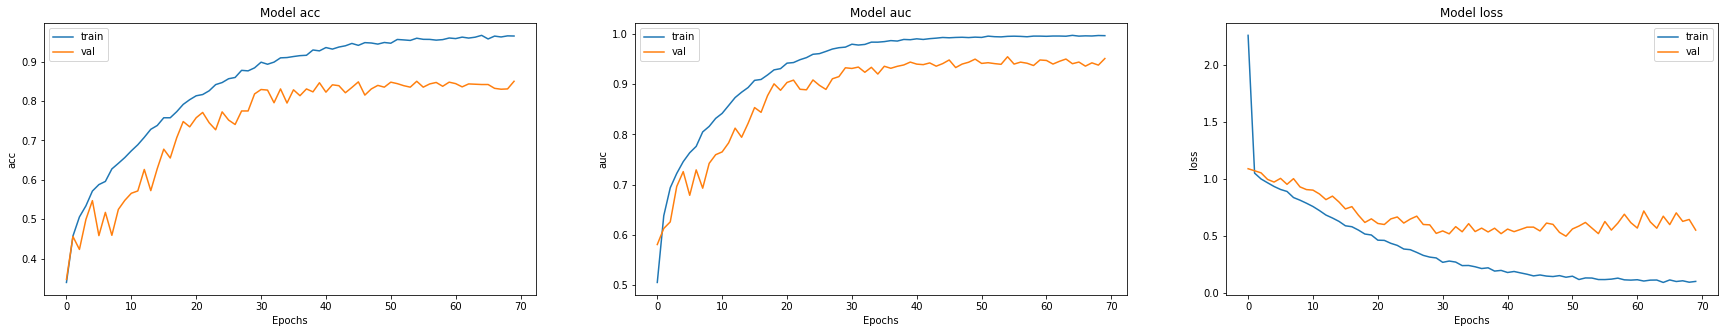

In [14]:
#Plotting the trend of the metrics during training

fig, ax = plt.subplots(1, 3, figsize = (30, 5))
ax = ax.ravel()

for i, metric in enumerate(["acc", "auc", "loss"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [15]:
#Evaluating the model on the data

#train_scores = model.evaluate(train_data, train_labels)
val_scores = model.evaluate(val_data, val_labels)
test_scores = model.evaluate(test_data, test_labels)

#print("Training Accuracy: %.2f%%"%(train_scores[1] * 100))
print("Validation Accuracy: %.2f%%"%(val_scores[1] * 100))
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

53/53 [==============================] - 1s 25ms/step - loss: 0.4644 - acc: 0.8705 - auc: 0.9602 - f1_score: 0.8692
Validation Accuracy: 85.01%
Testing Accuracy: 87.05%


In [16]:
#Predicting the test data

pred_labels = model.predict(test_data)

In [17]:
#Print the classification report of the tested data

#Since the labels are softmax arrays, we need to roundoff to have it in the form of 0s and 1s,
#similar to the test_labels
def roundoff(arr):
    """To round off according to the argmax of each predicted label array. """
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)

print(classification_report(test_labels, pred_labels, target_names=CLASSES))

              precision    recall  f1-score   support

          AD       0.88      0.95      0.91       573
          CN       0.87      0.85      0.86       540
         MCI       0.86      0.81      0.83       563

   micro avg       0.87      0.87      0.87      1676
   macro avg       0.87      0.87      0.87      1676
weighted avg       0.87      0.87      0.87      1676
 samples avg       0.87      0.87      0.87      1676



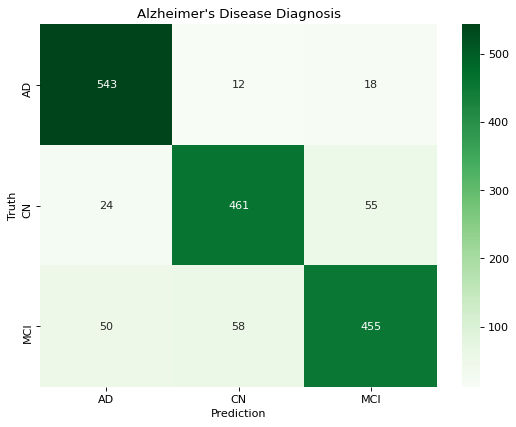

In [18]:
#Plot the confusion matrix to understand the classification in detail

pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels=CLASSES, yticklabels=CLASSES)

plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [19]:
#Printing some other classification metrics

print("Balanced Accuracy Score: {} %".format(round(BAS(test_ls, pred_ls) * 100, 2)))
print("Matthew's Correlation Coefficient: {} %".format(round(MCC(test_ls, pred_ls) * 100, 2)))

Balanced Accuracy Score: 86.98 %
Matthew's Correlation Coefficient: 80.64 %
